## Import libraries

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import itertools

## Functions

In [62]:
# root mean squared sum of differences
def calculate_rmssd(segment, feature):
    differences = np.diff(segment[feature])
    rmssd = np.sqrt(np.mean(differences ** 2))
    return rmssd

def calculate_variance(segment, feature):
    return np.var(segment[feature], ddof=1)

def calculate_std_dev(segment, feature):
    return np.std(segment[feature], ddof=1)

def calculate_range(segment, feature):
    return segment[feature].max() - segment[feature].min()

def calculate_mad(segment, feature):
    return np.mean(np.abs(segment[feature] - segment[feature].mean()))

#  coefficient of variation (CV) 
def calculate_cv(segment, feature):
    mean_value = segment[feature].mean()
    std_dev = segment[feature].std(ddof=1)
    return std_dev / mean_value if mean_value != 0 else np.nan

# volatility (standard deviation of logarithmic returns) 
def calculate_volatility(segment, feature):
    returns = np.log(segment[feature] / segment[feature].shift(1)).dropna()
    return np.std(returns, ddof=1)

## Combine patient data

In [260]:
def get_patient_stats(patient):
    glucose_df = pd.read_csv(f'data/gpt4o/6/data.csv')
    glucose_df = glucose_df[glucose_df['patient'] == int(patient[2])]
    glucose_df['date'] = pd.to_datetime(glucose_df['datetime']).dt.date

    segments_grouped = {str(date): segment for date, segment in glucose_df.groupby('date')}
    features = ['glucose']
    results = {'Date': list(segments_grouped.keys())}
    for feature in features:
        results[f'{feature}_RMSSD'] = [calculate_rmssd(segment, feature) for segment in segments_grouped.values()]
        results[f'{feature}_Variance'] = [calculate_variance(segment, feature) for segment in segments_grouped.values()]
        results[f'{feature}_SD'] = [calculate_std_dev(segment, feature) for segment in segments_grouped.values()]
        results[f'{feature}_Range'] = [calculate_range(segment, feature) for segment in segments_grouped.values()]
        results[f'{feature}_MAD'] = [calculate_mad(segment, feature) for segment in segments_grouped.values()]
        results[f'{feature}_CV'] = [calculate_cv(segment, feature) for segment in segments_grouped.values()]
        results[f'{feature}_Volatility'] = [calculate_volatility(segment, feature) for segment in segments_grouped.values()]

    results_df_grouped = pd.DataFrame(results)

    results_df_grouped.to_csv(f'patient_stats/patient_metrics_{patient}.csv', index=False)

In [261]:
patients = ['001', '002', '004', '006', '007', '008']
for patient in patients:
    get_patient_stats(patient)

## Get aggregate data

In [409]:
all_data = pd.DataFrame()
prediction_horizon = 6
for patient in patients:
    df = pd.read_csv(f'patient_stats/patient_metrics_{patient}.csv')
    food_data = pd.read_csv(f'food_data/gpt4o/{patient}.csv')
    food_data['date'] = food_data['datetime'].str.split(' ').str[0]
    food_data['date'] = food_data['date'].str.replace(':', '-')  

    insulin_data = pd.read_csv(f'diabetes_subset_pictures-glucose-food-insulin/{patient}/insulin.csv')
    insulin_data['date'] = insulin_data['date'].str.replace(':', '-') 
    df['Patient'] = patient

    gpt4o_preds = pd.read_csv(f'predictions/gpt4o/{prediction_horizon}/{patient}_preds.csv')
    gpt4o_preds['date'] = pd.to_datetime(gpt4o_preds['Datetime']).dt.date  

    nollm_preds = pd.read_csv(f'predictions/nollm/{prediction_horizon}/{patient}_preds.csv')
    nollm_preds['date'] = pd.to_datetime(nollm_preds['Datetime']).dt.date  
    
    day_rmses_gpt4o = []
    day_rmses_nollm = []
    num_meals = []
    
    day_sum_simple_sugars = []
    day_sum_complex_sugars = []
    day_sum_proteins = []
    day_sum_fats = []
    day_sum_weight = []
    day_sum_dietary_fibers = []

    num_insulin_doses = []
    day_sum_slow_insulin = []
    day_sum_fast_insulin = []


    patient_days = df['Date']
    for date in patient_days:

        day_preds_gpt4o = gpt4o_preds[gpt4o_preds['date'].astype('str')==date]
        day_preds_nollm = nollm_preds[nollm_preds['date'].astype('str')==date]

        day_food_data = food_data[food_data['date']==date]
        day_insulin_data = insulin_data[insulin_data['date']==date]
        if len(day_preds_gpt4o) > 0:

            day_rmse_gpt4o = np.sqrt(mean_squared_error(day_preds_gpt4o['Ground_truth'], day_preds_gpt4o['Predictions']))
            day_rmses_gpt4o.append(day_rmse_gpt4o)

            day_rmse_nollm = np.sqrt(mean_squared_error(day_preds_nollm['Ground_truth'], day_preds_nollm['Predictions']))
            day_rmses_nollm.append(day_rmse_nollm)

            num_meals.append(len(day_food_data))
            num_insulin_doses.append(len(day_insulin_data))
            day_sum_simple_sugars.append(np.sum(day_food_data['simple_sugars'].values))
            day_sum_complex_sugars.append(np.sum(day_food_data['complex_sugars'].values))
            day_sum_fats.append(np.sum(day_food_data['fats'].values))
            day_sum_proteins.append(np.sum(day_food_data['proteins'].values))
            day_sum_weight.append(np.sum(day_food_data['weight'].values))
            day_sum_dietary_fibers.append(np.sum(day_food_data['dietary_fibers'].values))
            day_sum_slow_insulin.append(np.sum(day_insulin_data['slow_insulin'].values))
            day_sum_fast_insulin.append(np.sum(day_insulin_data['fast_insulin'].values))
        else:
            df.drop(df[df['Date']==date].index, inplace=True)
    df['RMSE (gpt4o)'] = day_rmses_gpt4o
    df['RMSE (nollm)'] = day_rmses_nollm
    df['simple_sugars'] = day_sum_simple_sugars
    df['complex_sugars'] = day_sum_complex_sugars
    df['fats'] = day_sum_fats
    df['proteins'] = day_sum_proteins
    df['weight'] = day_sum_weight
    df['dietary_fibers'] = day_sum_dietary_fibers
    df['slow_insulin'] = day_sum_slow_insulin
    df['slow_insulin'] = df['slow_insulin'].fillna(0)
    df['fast_insulin'] = day_sum_fast_insulin
    df['fast_insulin'] = df['fast_insulin'].fillna(0)
    df['insulin'] = df['slow_insulin'] + df['fast_insulin']

    all_data = pd.concat([all_data, df])
    all_data.drop(['Date'], axis=1, inplace=True)
    all_data.fillna(0, inplace=True)

In [410]:
glucose_features = ['glucose_RMSSD', 'glucose_Variance', 'glucose_SD',
                    'glucose_Range', 'glucose_MAD', 'glucose_CV', 'glucose_Volatility']

sum_features = ['simple_sugars', 'complex_sugars', 'fats', 
                'proteins', 'weight', 'dietary_fibers', 
                'insulin']

for glucose, sum_feature in itertools.product(glucose_features, sum_features):
    new_column_name = f'{sum_feature}_to_{glucose}'
    all_data[new_column_name] = (all_data[sum_feature] + 1) / all_data[glucose] 

meal_features = ['simple_sugars', 'complex_sugars', 'fats', 
                'proteins', 'weight', 'dietary_fibers']

insulin_features = ['insulin']

for meal_feature, insulin_feature in itertools.product(meal_features, insulin_features):
    new_column_name = f'{meal_feature}_to_{insulin_feature}'
    all_data[new_column_name] = (all_data[meal_feature] + 1) / (all_data[insulin_feature] + 1)

In [467]:
patient_stats = all_data.groupby('Patient').agg({
    'glucose_RMSSD': ['mean', 'std'],
    'glucose_Variance': ['mean', 'std'],
    'glucose_SD': ['mean', 'std'],
    'glucose_Range': ['mean', 'std'],
    'glucose_MAD': ['mean', 'std'],
    'glucose_CV': ['mean', 'std'],
    'glucose_Volatility': ['mean', 'std'],
}).transpose()
patient_stats = round(patient_stats, 4)

In [468]:
patient_stats

Patient                        001        002        004        006  \
glucose_RMSSD      mean     5.1009     6.5335    10.9693     4.6818   
                   std      1.5473     1.7594     2.6070     2.1675   
glucose_Variance   mean  5355.0642  6911.3390  6580.4255  1918.5352   
                   std   4994.6841  4552.7829  3882.5756  1005.8217   
glucose_SD         mean    65.6881    77.3386    78.9043    42.3775   
                   std     35.3294    34.0969    21.7422    12.1333   
glucose_Range      mean   232.4348   269.9126   295.0480   159.4611   
                   std    114.2644   113.9742    51.3097    57.5991   
glucose_MAD        mean    55.4461    65.6456    65.5221    34.6430   
                   std     30.6605    31.0307    17.2110    10.6171   
glucose_CV         mean     0.3645     0.4115     0.4286     0.2467   
                   std      0.1628     0.1364     0.1257     0.0877   
glucose_Volatility mean     0.0338     0.0560     0.0754     0.0293   
                   std      0.0110     0.0163     0.0247     0.0125   

Patient                        007        008  
glucose_RMSSD      mean     7.6308     7.0897  
                   std      4.7748     3.6138  
glucose_Variance   mean  1727.9221  1851.9725  
                   std   1323.2439  1183.6918  
glucose_SD         mean    39.7265    40.1632  
                   std     13.6807    17.2803  
glucose_Range      mean   161.8034   168.6504  
                   std     67.0727    63.8389  
glucose_MAD        mean    30.8054    32.7587  
                   std      6.9973    14.6608  
glucose_CV         mean     0.2558     0.3156  
                   std      0.0804     0.1103  
glucose_Volatility mean     0.0523     0.0667  
                   std      0.0360     0.0314

In [473]:
def patient_stats_to_latex(df):
    def rename_metric(metric):
        return ' '.join(word.capitalize() for word in metric.split('_'))
    latex_table = """
\\begin{table}[h!]
\\centering
\\begin{tabular}{|l|*{""" + str(len(df.columns)) + """}{c|}}
\\hline
\\textbf{Metric} & """ + " & ".join([f"\\textbf{{{col}}}" for col in df.columns]) + """ \\\\
\\hline
"""
    metrics = df.index.get_level_values(0).unique()
    for metric in metrics:
        mean_row = df.loc[(metric, 'mean')]
        std_row = df.loc[(metric, 'std')]
        
        renamed_metric = rename_metric(metric)
        latex_table += f"\\multirow{{2}}{{*}}{{\\textbf{{{renamed_metric}}}}} & "
        latex_table += " & ".join([f"{mean:.2f}" for mean in mean_row])
        latex_table += " \\\\\n"
        latex_table += "& " + " & ".join([f"$\\pm {std:.2f}$" for std in std_row])
        latex_table += " \\\\\n\\hline\n"
    
    latex_table += """\\end{tabular}
\\caption{Patient Statistics}
\\label{tab:patient_stats}
\\end{table}
"""
    return latex_table

latex_table = patient_stats_to_latex(patient_stats)  
print(latex_table)  


\begin{table}[h!]
\centering
\begin{tabular}{|l|*{6}{c|}}
\hline
\textbf{Metric} & \textbf{001} & \textbf{002} & \textbf{004} & \textbf{006} & \textbf{007} & \textbf{008} \\
\hline
\multirow{2}{*}{\textbf{Glucose Rmssd}} & 5.10 & 6.53 & 10.97 & 4.68 & 7.63 & 7.09 \\
& $\pm 1.55$ & $\pm 1.76$ & $\pm 2.61$ & $\pm 2.17$ & $\pm 4.77$ & $\pm 3.61$ \\
\hline
\multirow{2}{*}{\textbf{Glucose Variance}} & 5355.06 & 6911.34 & 6580.43 & 1918.54 & 1727.92 & 1851.97 \\
& $\pm 4994.68$ & $\pm 4552.78$ & $\pm 3882.58$ & $\pm 1005.82$ & $\pm 1323.24$ & $\pm 1183.69$ \\
\hline
\multirow{2}{*}{\textbf{Glucose Sd}} & 65.69 & 77.34 & 78.90 & 42.38 & 39.73 & 40.16 \\
& $\pm 35.33$ & $\pm 34.10$ & $\pm 21.74$ & $\pm 12.13$ & $\pm 13.68$ & $\pm 17.28$ \\
\hline
\multirow{2}{*}{\textbf{Glucose Range}} & 232.43 & 269.91 & 295.05 & 159.46 & 161.80 & 168.65 \\
& $\pm 114.26$ & $\pm 113.97$ & $\pm 51.31$ & $\pm 57.60$ & $\pm 67.07$ & $\pm 63.84$ \\
\hline
\multirow{2}{*}{\textbf{Glucose Mad}} & 55.45 & 65.65 & 6

In [412]:
corr = all_data.corr(numeric_only=True)

In [413]:
all_data['RMSE_diff'] =  all_data['RMSE (gpt4o)'] - all_data['RMSE (nollm)']
correlations = all_data.drop(columns=['RMSE (gpt4o)', 'RMSE (nollm)']).corrwith(all_data['RMSE_diff'])

In [414]:
all_data

,glucose_RMSSD,glucose_Variance,glucose_SD,glucose_Range,glucose_MAD,glucose_CV,glucose_Volatility,Patient,RMSE (gpt4o),RMSE (nollm),...,weight_to_glucose_Volatility,dietary_fibers_to_glucose_Volatility,insulin_to_glucose_Volatility,simple_sugars_to_insulin,complex_sugars_to_insulin,fats_to_insulin,proteins_to_insulin,weight_to_insulin,dietary_fibers_to_insulin,RMSE_diff
0,2.924624,360.885958,18.996999,61.26188,15.379294,0.122220,0.018832,001,12.377561,13.514464,...,22355.959044,584.122445,1380.653053,0.192308,0.884615,1.076923,1.230769,16.192308,0.423077,-1.136903
1,4.617897,3423.662274,58.512069,232.43478,46.038139,0.292189,0.022933,001,17.145020,18.193980,...,37108.433822,828.507923,1177.353364,1.148148,3.481481,1.185185,1.222222,31.518519,0.703704,-1.048961
2,4.619752,13228.686795,115.016028,360.36400,101.142123,0.583812,0.031869,001,17.774403,18.746038,...,35489.274164,658.952040,690.330709,2.181818,6.636364,2.409091,2.590909,51.409091,0.954545,-0.971635
3,5.696879,9712.480192,98.551916,354.95854,80.464153,0.503942,0.041596,001,19.052043,18.937185,...,38873.661462,625.055781,673.136995,3.214286,3.607143,1.642857,2.285714,57.750000,0.928571,0.114858
4,7.633596,3412.006279,58.412381,219.82204,50.609429,0.349545,0.044678,001,16.777738,18.654652,...,48815.446052,760.992740,537.171346,5.916667,7.958333,2.625000,2.791667,90.875000,1.416667,-1.876914
5,5.112879,1992.663563,44.639260,165.76744,39.043609,0.335496,0.042657,001,13.902783,17.181743,...,25341.512642,398.525176,23.442657,111.000000,131.000000,50.000000,42.000000,1081.000000,17.000000,-3.278960
0,3.801362,532.996975,23.086727,86.48736,18.407350,0.243789,0.052242,002,20.543285,23.806964,...,6718.715302,114.849834,172.274751,0.666667,5.666667,1.777778,2.333333,39.000000,0.666667,-3.263679
1,8.126204,12603.473652,112.265193,338.74216,100.992679,0.615055,0.073664,002,25.815988,26.229583,...,10873.749702,217.203490,13.575218,11.000000,71.000000,56.000000,46.000000,801.000000,16.000000,-0.413595
2,6.966251,4765.106068,69.029748,230.63296,58.957686,0.411686,0.064611,002,20.017226,20.054313,...,10849.511908,294.066657,216.680694,0.785714,7.571429,1.214286,1.857143,50.071429,1.357143,-0.037088
3,7.872718,9105.380348,95.422117,356.76036,83.693969,0.439422,0.059011,002,24.638511,25.049336,...,8489.968370,186.406491,288.082759,1.235294,2.411765,1.823529,2.117647,29.470588,0.647059,-0.410825


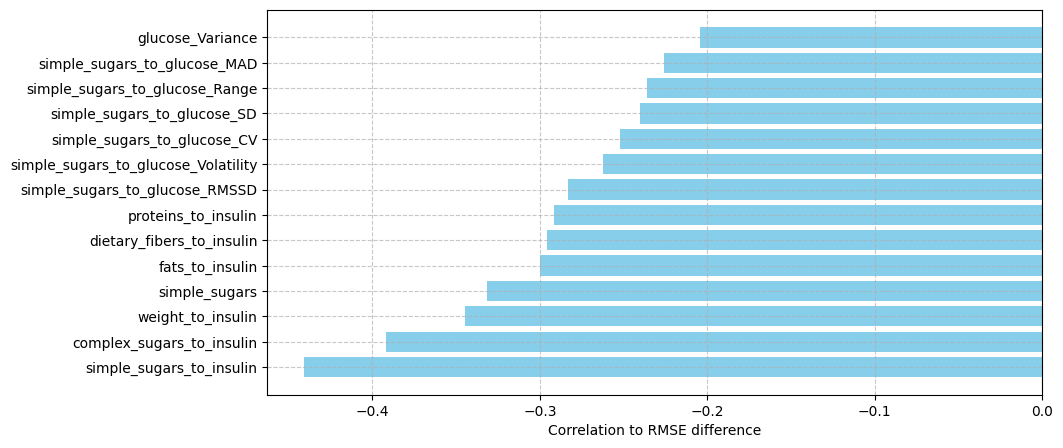

In [480]:
corr_df = pd.DataFrame(correlations, columns=['Correlation'])  
  
# Drop the specified columns  
corr_df.drop(['RMSE_diff', 'Patient'], inplace=True)  
  
# Sort by absolute correlation values  
corr_df['Absolute Correlation'] = corr_df['Correlation'].abs()  
corr_df.sort_values(by='Absolute Correlation', ascending=False, inplace=True)  
top_corr_df = corr_df[corr_df['Absolute Correlation']> 0.2]
# Plot the original correlation values  
plt.figure(figsize=(10, 5))  
plt.barh(top_corr_df.index, top_corr_df['Correlation'], color='skyblue')  
plt.xlabel('Correlation to RMSE difference')  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()  

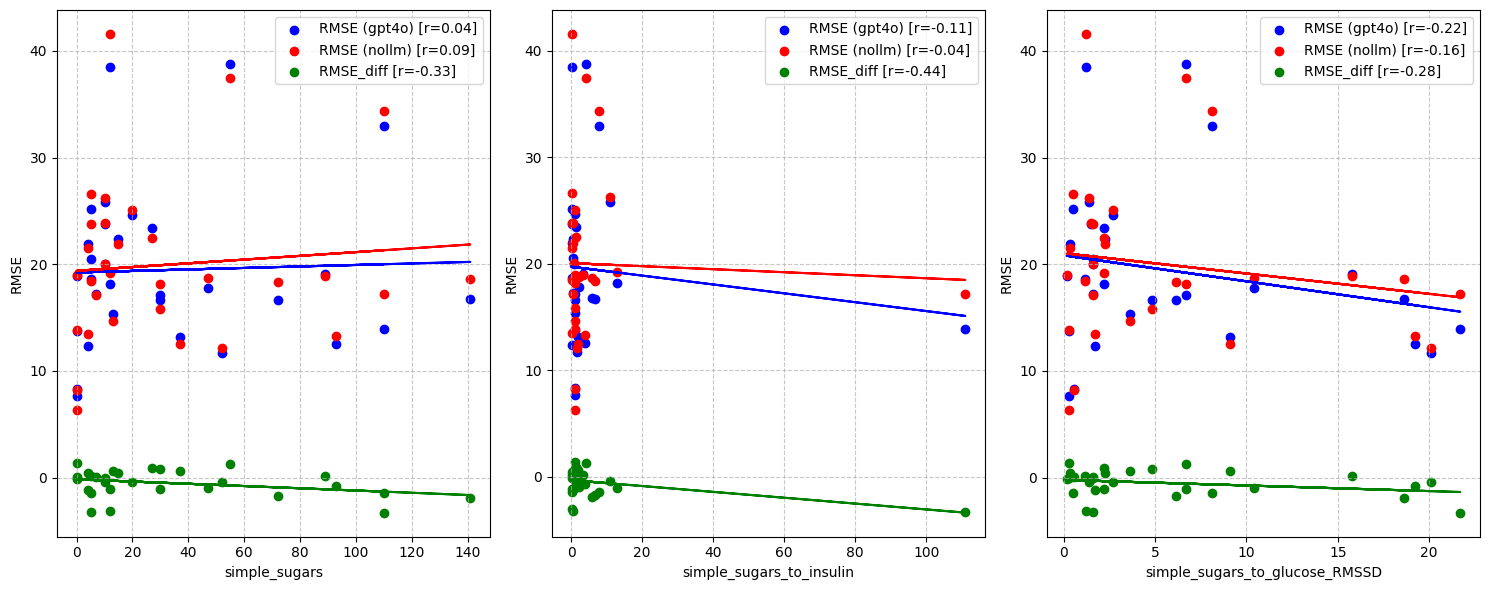

In [476]:
features = ['simple_sugars', 'simple_sugars_to_insulin', 'simple_sugars_to_glucose_RMSSD']  
  
# Create a figure with 1 row and 3 columns  
fig, axs = plt.subplots(1, 3, figsize=(15, 6))  
  
for i, feature in enumerate(features):  
    corr_gpt4o = np.corrcoef(all_data[feature], all_data['RMSE (gpt4o)'])[0, 1]  
    corr_nollm = np.corrcoef(all_data[feature], all_data['RMSE (nollm)'])[0, 1]  
    corr_diff = np.corrcoef(all_data[feature], all_data['RMSE_diff'])[0, 1]  
  
    axs[i].scatter(all_data[feature], all_data['RMSE (gpt4o)'], color='blue', label=f'RMSE (gpt4o) [r={corr_gpt4o:.2f}]')  
    axs[i].scatter(all_data[feature], all_data['RMSE (nollm)'], color='red', label=f'RMSE (nollm) [r={corr_nollm:.2f}]')  
    axs[i].scatter(all_data[feature], all_data['RMSE_diff'], color='green', label=f'RMSE_diff [r={corr_diff:.2f}]')  
  
    # Add trend lines  
    z_gpt4o = np.polyfit(all_data[feature], all_data['RMSE (gpt4o)'], 1)  
    p_gpt4o = np.poly1d(z_gpt4o)  
    axs[i].plot(all_data[feature], p_gpt4o(all_data[feature]), color='blue')  
      
    z_nollm = np.polyfit(all_data[feature], all_data['RMSE (nollm)'], 1)  
    p_nollm = np.poly1d(z_nollm)  
    axs[i].plot(all_data[feature], p_nollm(all_data[feature]), color='red')  
      
    z_diff = np.polyfit(all_data[feature], all_data['RMSE_diff'], 1)  
    p_diff = np.poly1d(z_diff)  
    axs[i].plot(all_data[feature], p_diff(all_data[feature]), color='green')  
  
    # Labels, title, and grid  
    axs[i].set_xlabel(feature)  
    axs[i].set_ylabel('RMSE')  
    axs[i].legend()  
    axs[i].grid(True, linestyle='--', alpha=0.7)  
  
# Adjust layout  
plt.tight_layout()  
plt.show()  